<a href="https://colab.research.google.com/github/lrrong2020/A/blob/main/FYP_0304.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


Prep

In [ ]:
!cp /content/gdrive/MyDrive/Kaggle/unzip/data.zip /home




In [ ]:
%cd /home
!unzip -nq /home/data.zip "train/*"

/home


In [ ]:
!rm /home/data.zip

#GitHub

In [ ]:
import pandas as pd #For reading csv files.
import numpy as np
import os
import matplotlib.pyplot as plt #For plotting.
import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader #For working with data.
from torchvision import models,transforms #For pretrained models,image transformations.
from torch.optim.lr_scheduler import StepLR

#manual seed for reproductivity and potential performance improvement
torch.manual_seed(3407)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [ ]:
!cp /content/gdrive/MyDrive/Kaggle/unzip/allLabels.csv /home

In [ ]:

path = "/home/"

#label csv
all_df = pd.read_csv(f"{path}allLabels.csv")

from sklearn.model_selection import train_test_split
# subset for hyperparameters tuning

part = 0.80
train_df, drop_df = train_test_split(all_df, test_size=part, random_state=42)
test_sample_size = round(7000 * (1 - part) )  #roughtly 1/3
train_df, test_df = train_test_split(train_df, test_size=test_sample_size, random_state=42)

# Assuming train_df is your original training DataFrame
# test_sample_size = 7000 # roughtly 1/3
# train_df, test_df = train_test_split(all_df, test_size=test_sample_size, random_state=42)

# Now split the remaining training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f'No.of.training_samples: {len(train_df)}')
print(f'No.of.testing_samples: {len(test_df)}')
print(f'No.of.val_samples: {len(valid_df)}')

No.of.training_samples: 5062
No.of.testing_samples: 1400
No.of.val_samples: 563


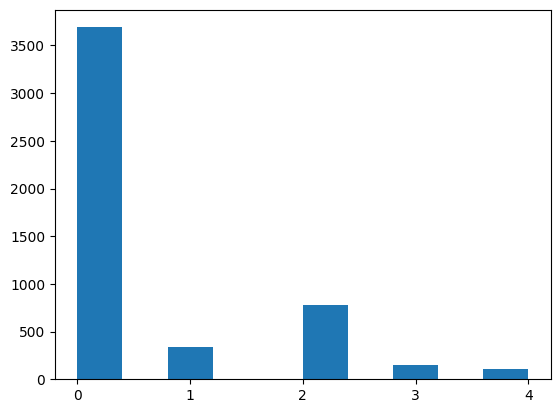

In [ ]:
#Histogram of label counts.
train_df.level.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show()

In [ ]:
class_counts = train_df['level'].value_counts().to_dict()
print(class_counts)


{0: 3691, 2: 777, 1: 340, 3: 146, 4: 108}


In [ ]:
majority_class_count = max(class_counts.values())
print(majority_class_count)

3691


In [ ]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['level'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

print(class_weights) #Prints the calculated weights for the classes.

tensor([0.2743, 2.9776, 1.3030, 6.9342, 9.3741], device='cuda:0')


In [ ]:
from torchvision.transforms import functional as F
import random

class Augmenter:
    def __init__(self, rotate=True, flip_lr=True, flip_tb=True):
        self.rotate = rotate
        self.flip_lr = flip_lr
        self.flip_tb = flip_tb

    def __call__(self, img):
        if self.rotate:
            img = img.rotate(random.uniform(-25, 25))
        if self.flip_lr and random.random() > 0.5:
            img = F.hflip(img)
        if self.flip_tb and random.random() > 0.5:
            img = F.vflip(img)
        return img

augmenter = Augmenter()

In [ ]:
from torchvision.transforms import functional as F
from PIL import Image
import random
import numpy as np

class AugmenterAGG:
    def __init__(self, rotate=True, flip_lr=True, flip_tb=True, translate=True):
        self.rotate = rotate
        self.flip_lr = flip_lr
        self.flip_tb = flip_tb
        self.translate = translate

    def __call__(self, img):
        if self.rotate:
            img = img.rotate(random.uniform(0, 90))
        if self.flip_lr and random.random() > 0.5:
            img = F.hflip(img)
        if self.flip_tb and random.random() > 0.5:
            img = F.vflip(img)
        if self.translate:
            img = F.affine(img, 0, (random.randint(-30, 30), random.randint(-30, 30)), 1, 0)
        return img

augmenter_agg = AugmenterAGG()


In [ ]:
#For getting a random image from our training set.
# num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
# sample_image = (f'{path}train/{train_df["image"][num]}.jpeg')#Image file.
# sample_image = Image.open(sample_image)
# plt.imshow(sample_image)
# plt.axis('off')
# plt.title(f'Class: {train_df["level"][num]}') #Class of the random image.
# plt.show()

In [ ]:
class dataset(Dataset):
    def __init__(self,df,data_path,image_transform=None,augment_transform=None,augment_transform_agg=None,train=True):
        super(Dataset,self).__init__()
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.augment_transform = augment_transform
        self.augment_transform_agg = augment_transform_agg
        self.train = train
        self.minority_classes = [1, 2, 3, 4]  # specify minority classes

    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        image_id = self.df['image'][index]
        image = Image.open(f'{self.data_path}/{image_id}.jpeg')
        label = self.df['level'][index] if self.train else None

        if self.train and self.augment_transform and label == 2:
            image = self.augment_transform_agg(image)
        if self.train and self.augment_transform and label in self.minority_classes:
            image = self.augment_transform(image)

        if self.image_transform:
            image = self.image_transform(image)

        return (image, label) if self.train else image

In [ ]:
image_transform = transforms.Compose([
    transforms.Resize([512,512]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Create the datasets
train_set = dataset(train_df, f'{path}train', image_transform=image_transform, augment_transform=augmenter, augment_transform_agg=augmenter_agg)
test_set = dataset(test_df, f'{path}train', image_transform=image_transform)
valid_set = dataset(valid_df, f'{path}train', image_transform=image_transform)

In [ ]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
from torchvision.models import resnet50,ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.DEFAULT) #Downloads the resnet50 model which is pretrained on Imagenet dataset.
# Replace the Final layer of pretrained resnet50
model.fc = nn.Sequential(
    nn.Linear(2048, 5),
)

In [ ]:
model = model.to(device) #Moves the model to the device.

In [ ]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.

    total = 0
    correct = 0
    running_loss = 0

    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.


        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.

        running_loss += loss.item()

        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        accuracy = 100*(correct/total)

        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.

        #for memory
        torch.cuda.empty_cache()

        # Print some information every 100 batches
        if batch % 70 == 0:
            print(f'Batch {batch}/{len(dataloader)} processed, running loss: {running_loss:.6f}, correct predictions: {correct}, total: {total}')


    avg_loss = running_loss/len(dataloader) # Average loss for a single batch

    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    torch.save(model, '/content/gdrive/MyDrive/Kaggle/unzip/DR_new_aug_4.pt')
    return avg_loss, accuracy

In [ ]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.eval() #Sets the model for evaluation.

    total = 0
    correct = 0
    running_loss = 0

    with torch.no_grad(): #No need to calculate the gradients.

        for x,y in dataloader:

            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss

            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            accuracy = 100*(correct/total)

    avg_loss = running_loss/len(dataloader) #Average loss per batch.

    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    return avg_loss, accuracy

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'g', label='Training Loss')
    plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'g', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.

    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.

    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    # Initialize the learning rate scheduler
    # scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

    best_valid_loss = float('inf')
    no_improve_epoch = 0

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        print("Epoch: %d, Learning Rate: %f " % (epoch, optimizer.param_groups[0]['lr']))
        train_loss, train_accuracy = train(train_dataloader,model,loss_fn,optimizer)
        valid_loss, valid_accuracy = validate(valid_dataloader,model,loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

        plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies)


        # Check if the validation loss improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improve_epoch = 0

            # Save the model when validation loss improves
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improve_epoch += 1

        # If the validation loss did not improve for 'patience' epochs, stop training
        if no_improve_epoch >= patience:
            print(f'Early stopping at epoch {epoch+1}, the validation loss did not improve for the last {patience} epochs')

            # Save to CSV
            df.to_csv('training_validation_metrics.csv', index=False)
            break

        # Step the learning rate scheduler
        # scheduler.step()
        scheduler.step(valid_loss)

        df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)

    print('\nTraining has completed!')

    # Save to CSV
    df.to_csv('training_validation_metrics.csv', index=False)

    return train_losses,valid_losses


Epoch 1/50
-------------------------------
Epoch: 0, Learning Rate: 0.005000 
Batch 0/317 processed, running loss: 1.272974, correct predictions: 7, total: 16
Batch 70/317 processed, running loss: 97.587120, correct predictions: 698, total: 1136
Batch 140/317 processed, running loss: 189.986072, correct predictions: 1520, total: 2256
Batch 210/317 processed, running loss: 275.021149, correct predictions: 2376, total: 3376
Batch 280/317 processed, running loss: 354.253914, correct predictions: 3257, total: 4496

Training Loss per batch = 1.230378	Accuracy on Training set = 73.686290% [3730/5062]

Validation Loss per batch = 1.360659	Accuracy on Validation set = 74.422735% [419/563]
Train Loss: 1.2304, Train Accuracy: 73.6863
Valid Loss: 1.3607, Valid Accuracy: 74.4227


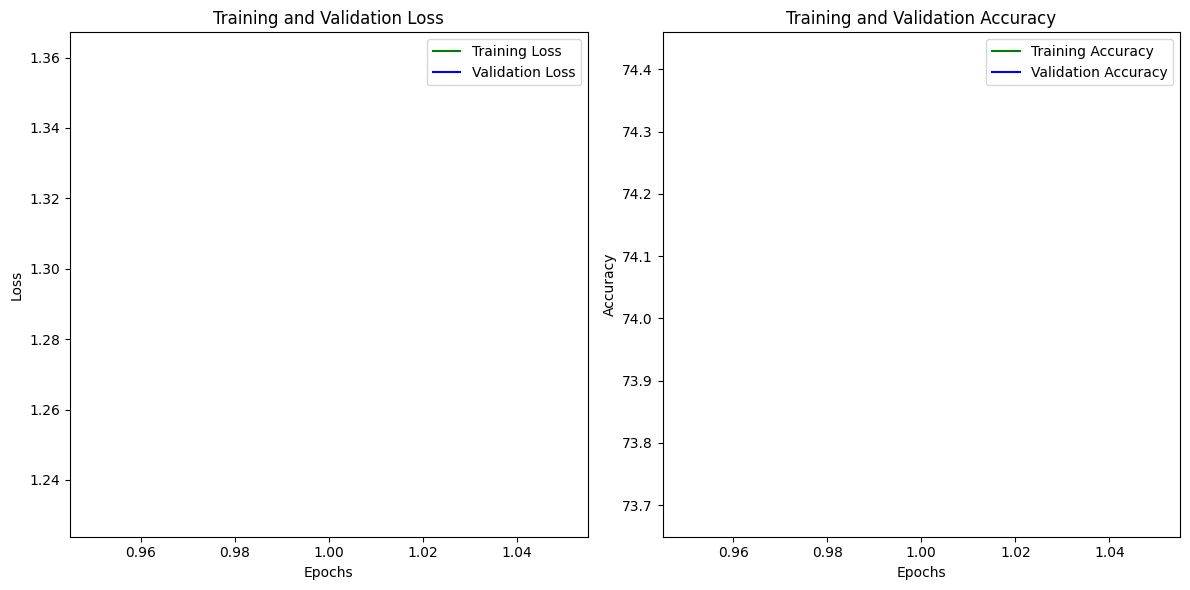

<ipython-input-87-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)



Epoch 2/50
-------------------------------
Epoch: 1, Learning Rate: 0.005000 
Batch 0/317 processed, running loss: 1.113528, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 69.233272, correct predictions: 948, total: 1136
Batch 140/317 processed, running loss: 137.289567, correct predictions: 1878, total: 2256


In [ ]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.005, weight_decay=1e-5)
nb_epochs = 50
patience = 35

#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience)

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/unzip

In [ ]:
model = torch.load("DR_ResNet50_test.pt")
model.eval()  # Set the model to evaluation mode

# Store all the model predictions for the test set
all_preds = []
all_labels = []

# No need to track gradients for evaluation, saves memory and computations
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs, labels = inputs.cuda(), labels.cuda() # add this line

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

FileNotFoundError: [Errno 2] No such file or directory: 'DR_ResNet50_test.pt'

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds))

# For multiclass case:
num_classes = cm.shape[0]  # assuming cm is a square matrix

for i in range(num_classes):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp  # sum across the row, excluding the diagonal element
    fp = cm[:, i].sum() - tp  # sum down the column, excluding the diagonal element
    tn = cm.sum() - fn - fp - tp

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"For class {i}, Sensitivity: {sensitivity}, Specificity: {specificity}")


In [ ]:
!nvidia-smi

In [ ]:
!pwd

In [ ]:
!zip -r data.zip test train